In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

import holidays
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv(r'./data/train.csv')
international_trade = pd.read_csv(r'./data/international_trade.csv')
test = pd.read_csv(r'./data/test.csv')

In [3]:
def group_season(df):
    df.loc[(df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5), 'season'] = '봄'
    df.loc[(df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8), 'season'] = '여름'
    df.loc[(df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11), 'season'] = '가을'
    df.loc[(df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2), 'season'] = '겨울'
    return df['season']

def holiday(df):
    kr_holidays = holidays.KR()
    df['holiday'] = df.timestamp.apply(lambda x: 'holiday' if x in kr_holidays else 'non-holiday')
    return df['holiday']

def cyclical_feature(df, time=12):
    df['sin_time'] = np.sin(2*np.pi*df.month/time)
    df['cos_time'] = np.cos(2*np.pi*df.month/time)

In [4]:
# train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
# train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))
train['Weekday'] = pd.to_datetime(train['timestamp']).dt.weekday
train['is_weekend'] = train['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
train['total_item_value'] = train['item']+train['corporation']+train['location']
train['location_month'] = train['location'].astype(str) + "_" + train['month'].astype(str)
cyclical_feature(train)

# test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
# test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))
test['Weekday'] = pd.to_datetime(test['timestamp']).dt.weekday
test['is_weekend'] = test['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
test['total_item_value'] = test['item']+test['corporation']+test['location']
test['location_month'] = test['location'].astype(str) + "_" + test['month'].astype(str)
cyclical_feature(test)


train['season'] = group_season(train)
test['season'] = group_season(test)

train['holiday'] = holiday(train)
test['holiday'] = holiday(test)



Q1 = train['price(원/kg)'].quantile(0.25)
Q3 = train['price(원/kg)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train = train[(train['price(원/kg)'] >= lower_bound) & (train['price(원/kg)'] <= upper_bound)]



x = train.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
y = train['price(원/kg)']

x_test = test.drop(columns=['ID', 'timestamp'])

qual_col = ['item', 'corporation', 'location', 'season', 'holiday', 'total_item_value', 'location_month']

for i in qual_col:      
    le = LabelEncoder()
    x[i]=le.fit_transform(x[i])
    x_test[i]=le.transform(x_test[i])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1103)

RMSE: 481.87762553758955


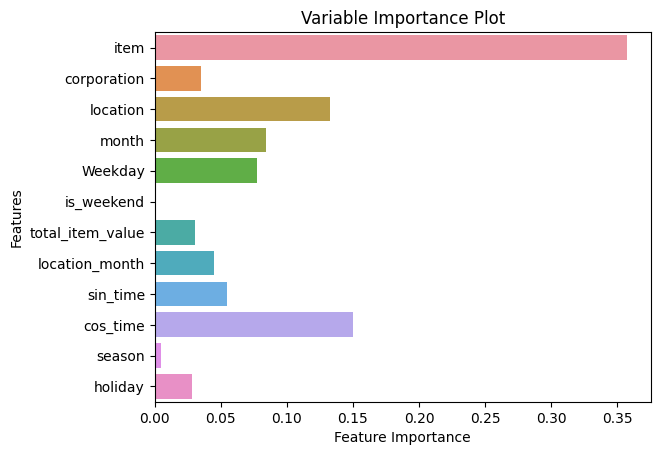

In [5]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_val)
rmse = mean_squared_error(y_val, xgb_pred, squared=False)
print("RMSE:", rmse)

feature_importance = xgb.feature_importances_
sns.barplot(x=feature_importance, y=x_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Variable Importance Plot')
plt.show()

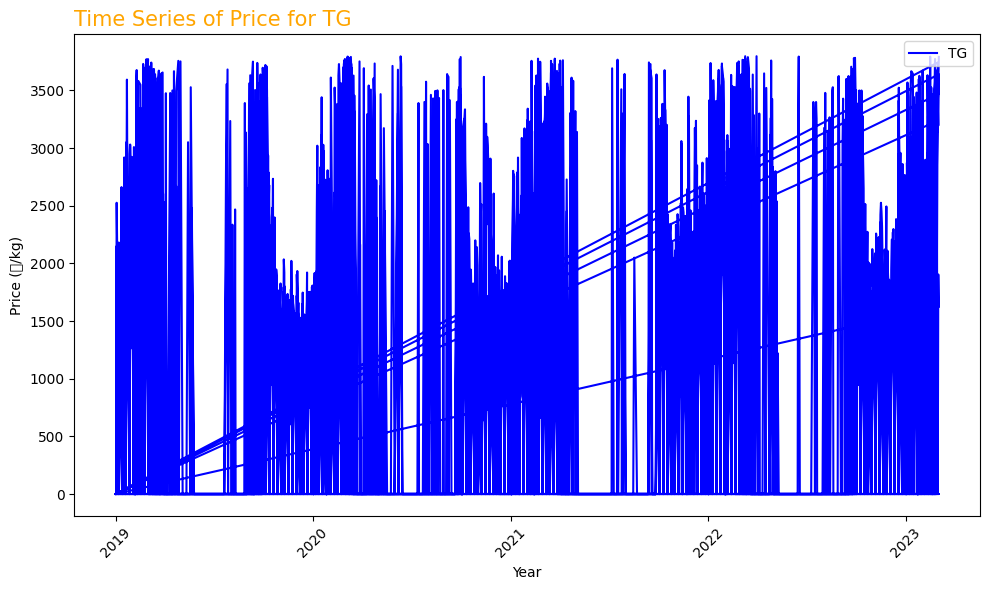

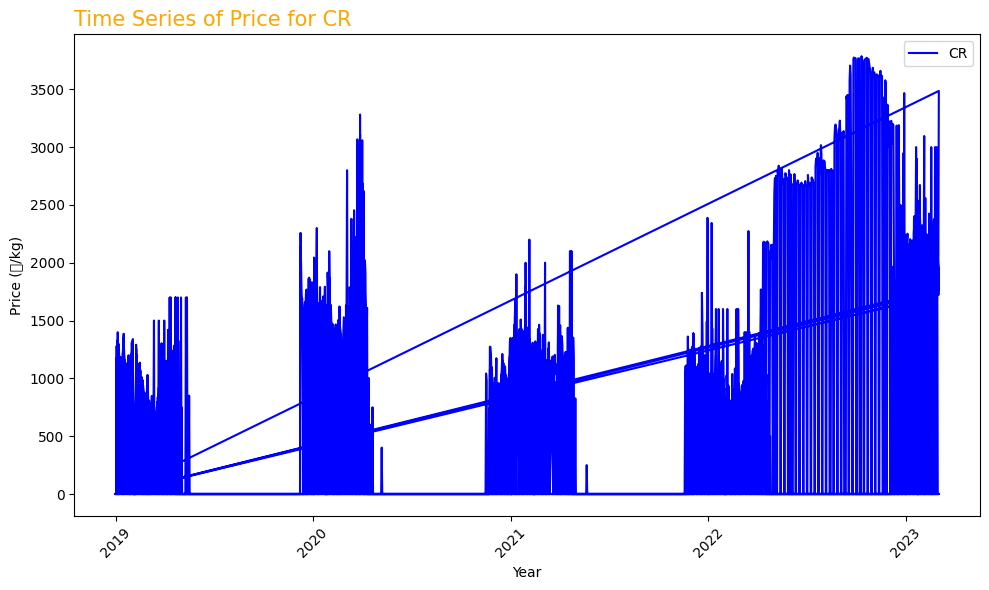

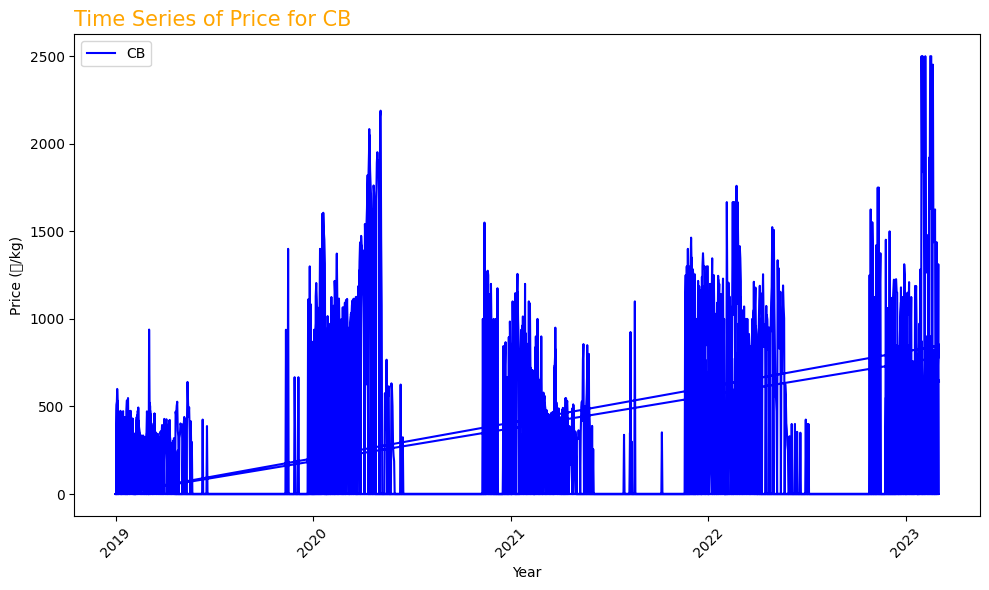

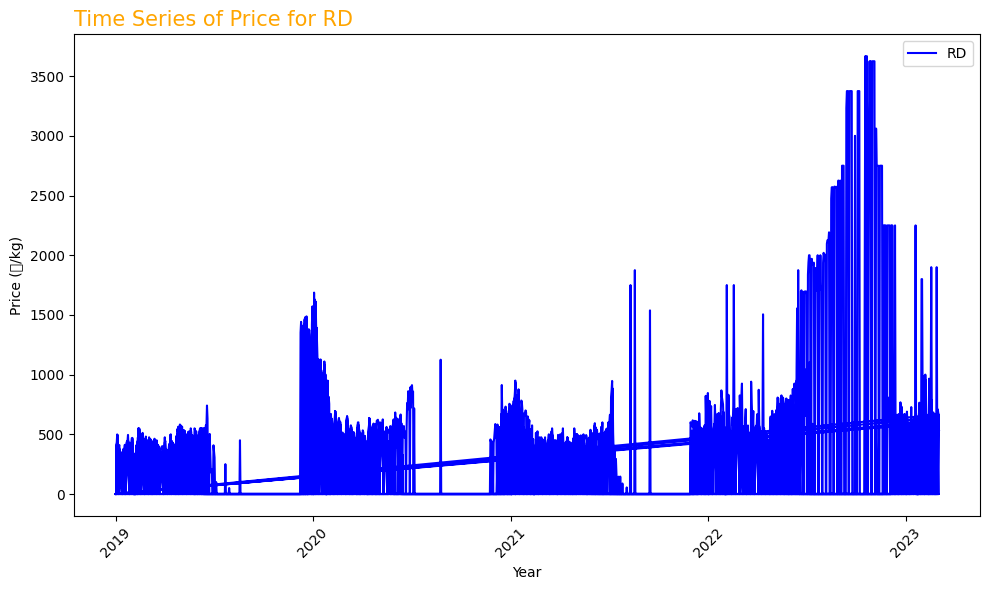

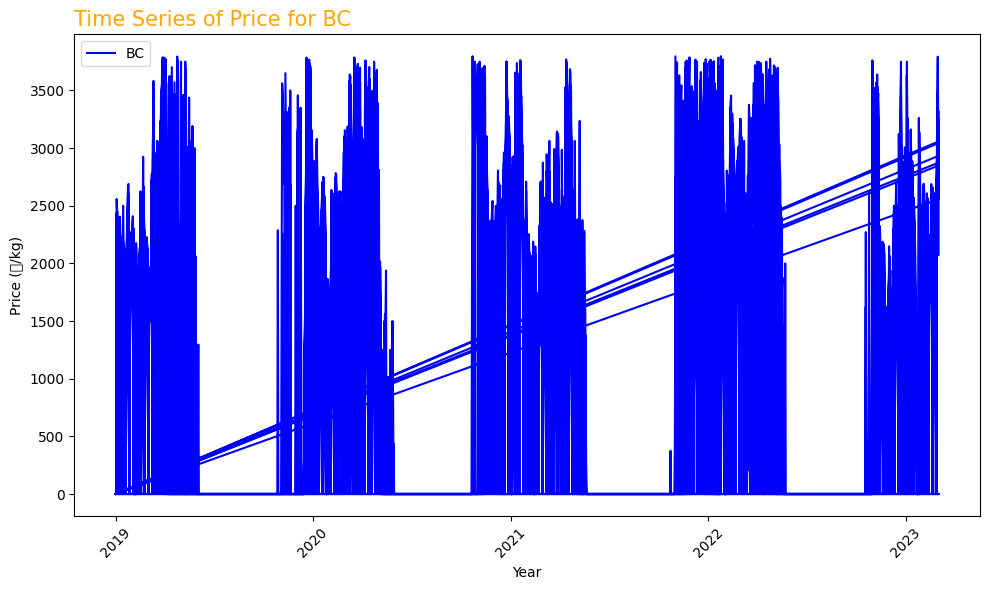

In [6]:
import matplotlib.dates as mdates

def plot_price_by_item_with_year_only(item_name, dataframe):
    """Plot the price(원/kg) over timestamp for a specific item with only year on the x-axis."""
    subset = dataframe[dataframe['item'] == item_name]
    
    plt.figure(figsize=(10,6))
    plt.plot(pd.to_datetime(subset['timestamp']), subset['price(원/kg)'], label=item_name, color='blue')
    
    plt.title(f'Time Series of Price for {item_name}', loc='left', fontsize=15, fontweight=0, color='orange')
    plt.xlabel('Year')
    plt.ylabel('Price (원/kg)')
    plt.legend()
    
    # Format x-axis to show only year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example code usage for the first unique item
items = train['item'].unique()
for item in items:  # Displaying only for the first item as an example
    plot_price_by_item_with_year_only(item, train)


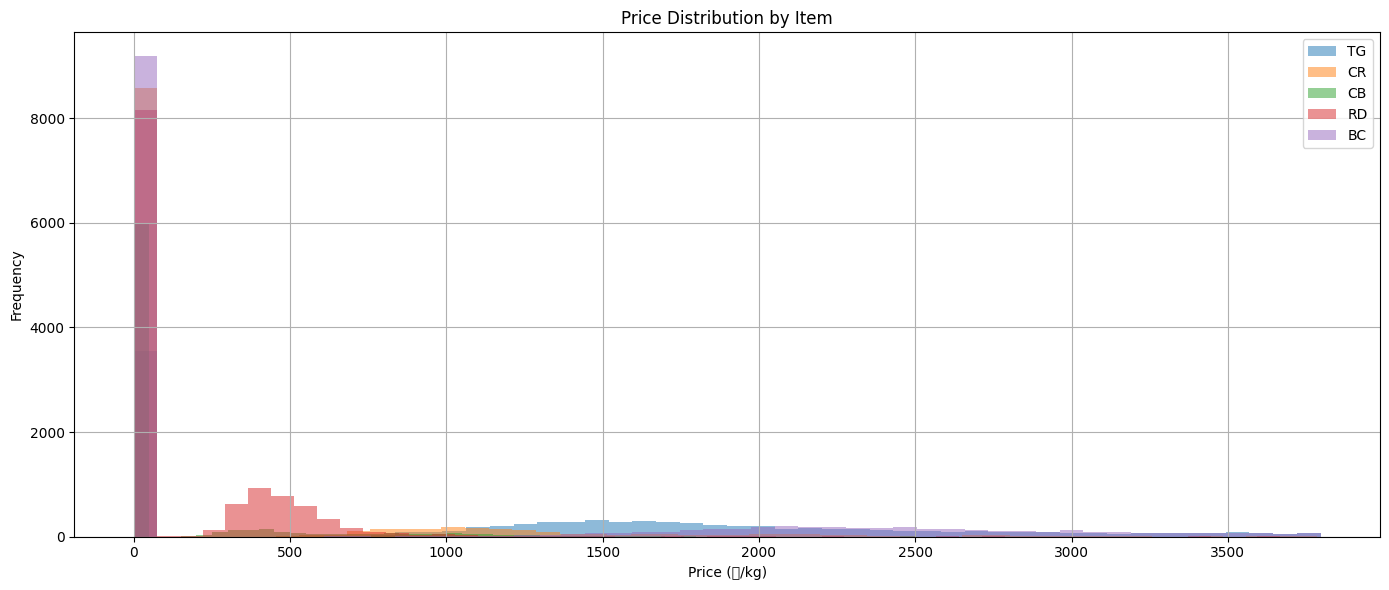

In [7]:
plt.figure(figsize=(14, 6))
for item in train['item'].unique():
    subset = train[train['item'] == item]
    plt.hist(subset['price(원/kg)'], bins=50, alpha=0.5, label=item)

plt.title('Price Distribution by Item')
plt.xlabel('Price (원/kg)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

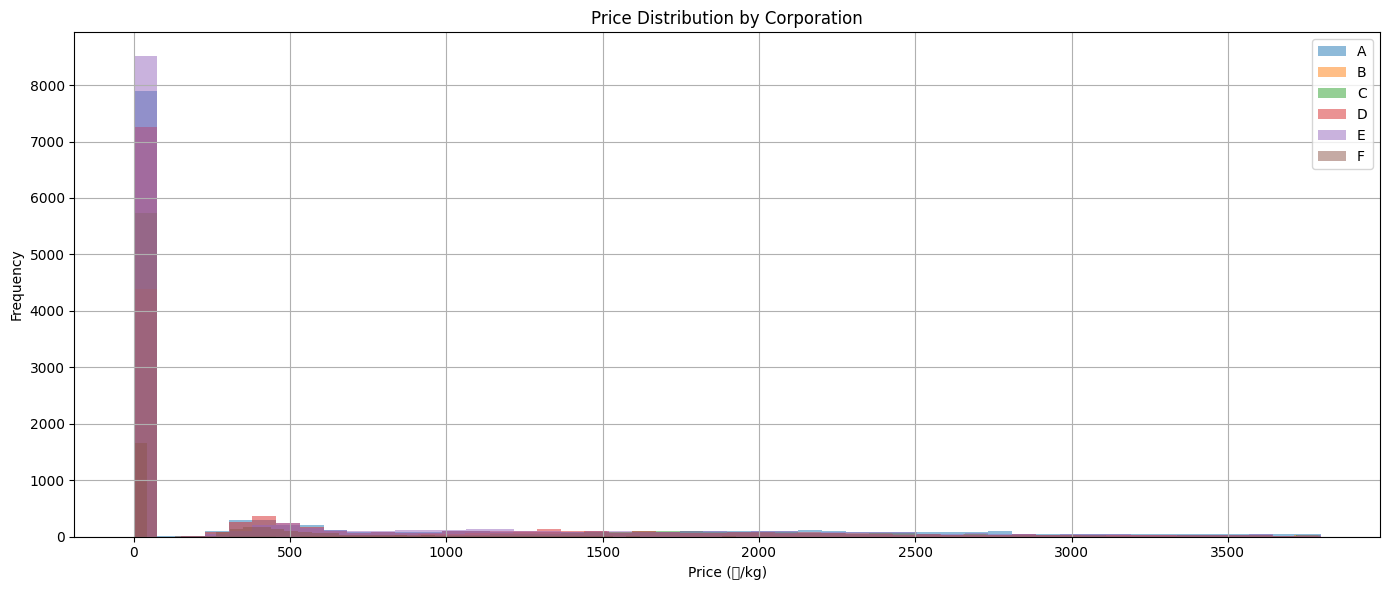

In [8]:
# Plotting the price distribution for each corporation
plt.figure(figsize=(14, 6))
for corp in train['corporation'].unique():
    subset = train[train['corporation'] == corp]
    plt.hist(subset['price(원/kg)'], bins=50, alpha=0.5, label=corp)

plt.title('Price Distribution by Corporation')
plt.xlabel('Price (원/kg)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


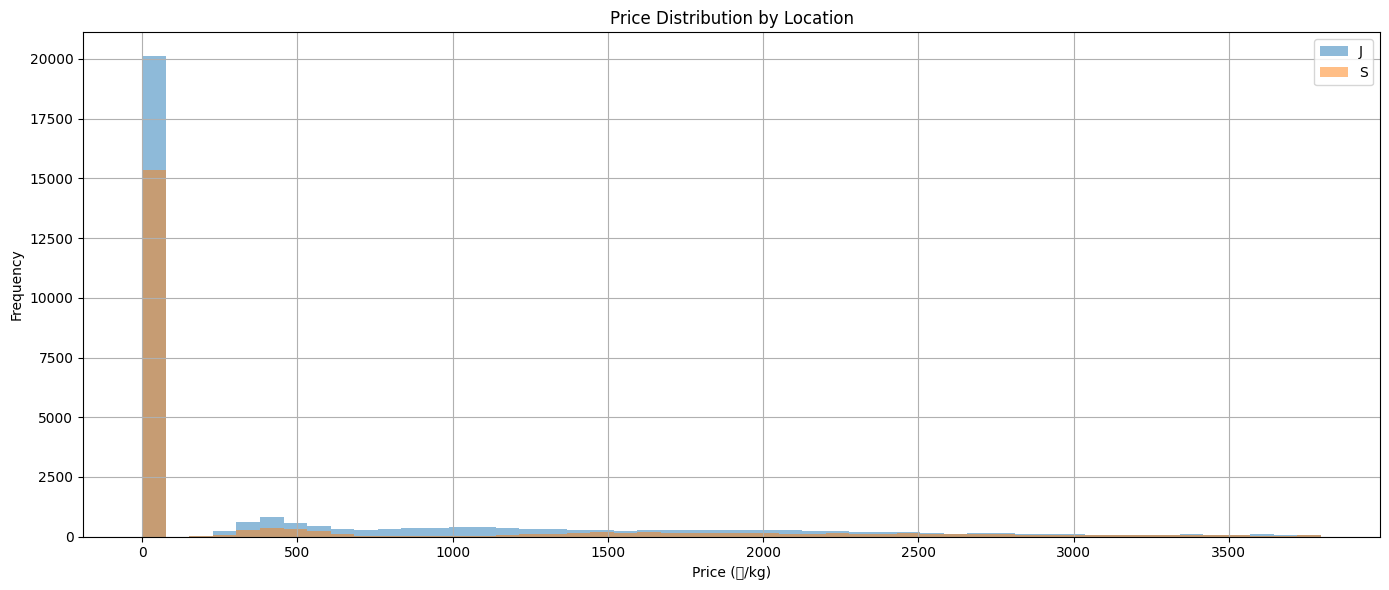

In [9]:
# Plotting the price distribution for each location
plt.figure(figsize=(14, 6))
for loc in train['location'].unique():
    subset = train[train['location'] == loc]
    plt.hist(subset['price(원/kg)'], bins=50, alpha=0.5, label=loc)

plt.title('Price Distribution by Location')
plt.xlabel('Price (원/kg)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
train

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),month,Weekday,is_weekend,total_item_value,location_month,sin_time,cos_time,season,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,1,1,0,TGAJ,J_1,0.500000,8.660254e-01,겨울,holiday
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,1,2,0,TGAJ,J_1,0.500000,8.660254e-01,겨울,non-holiday
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,1,3,0,TGAJ,J_1,0.500000,8.660254e-01,겨울,non-holiday
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,1,4,0,TGAJ,J_1,0.500000,8.660254e-01,겨울,non-holiday
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,1,5,1,TGAJ,J_1,0.500000,8.660254e-01,겨울,non-holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2,0,0,RDFJ,J_2,0.866025,5.000000e-01,겨울,non-holiday
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2,1,0,RDFJ,J_2,0.866025,5.000000e-01,겨울,non-holiday
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,3,2,0,RDFJ,J_3,1.000000,6.123234e-17,봄,holiday
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,3,3,0,RDFJ,J_3,1.000000,6.123234e-17,봄,non-holiday


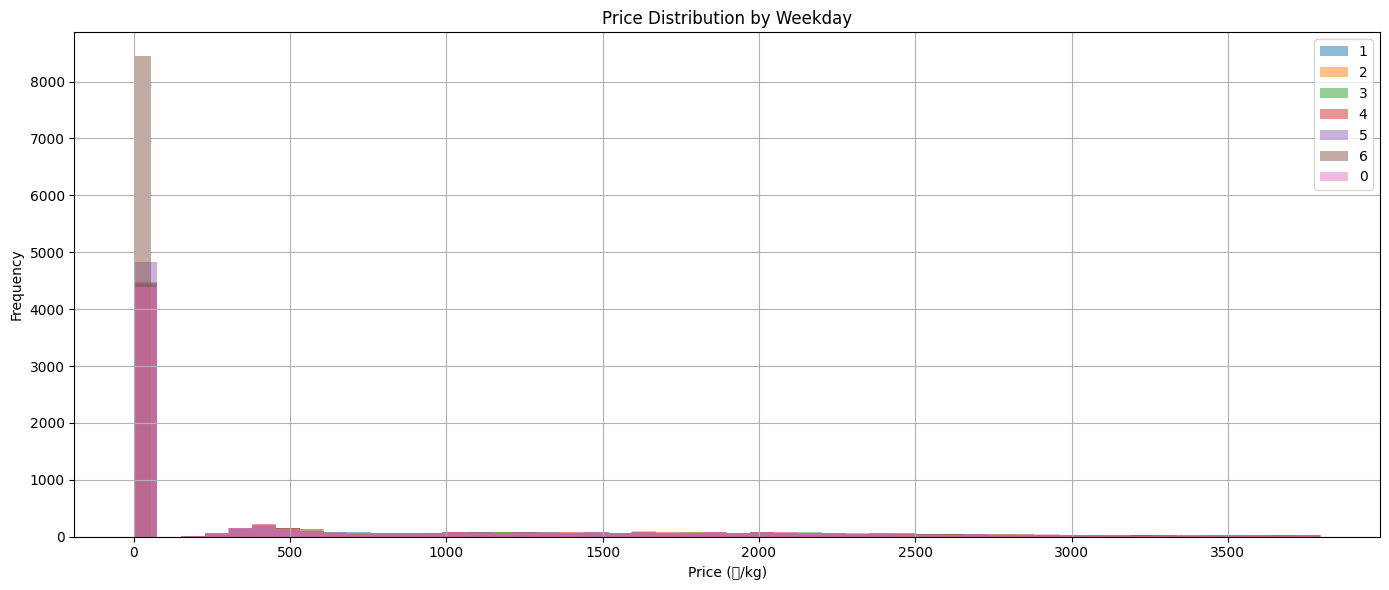

In [11]:
# Plotting the price distribution for each corporation
plt.figure(figsize=(14, 6))
for corp in train['Weekday'].unique():
    subset = train[train['Weekday'] == corp]
    plt.hist(subset['price(원/kg)'], bins=50, alpha=0.5, label=corp)

plt.title('Price Distribution by Weekday')
plt.xlabel('Price (원/kg)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Filter the dataframe where 'price(원/kg)' is 0
zero_price_df = train[train['price(원/kg)'] == 0]

# Display basic statistics and characteristics of the zero price data
summary = {
    "Total Rows": len(zero_price_df),
    "Unique Items": zero_price_df['item'].nunique(),
    "Unique Corporations": zero_price_df['corporation'].nunique(),
    "Unique Locations": zero_price_df['location'].nunique(),
    "Date Range": (zero_price_df['timestamp'].min(), zero_price_df['timestamp'].max()),
    "Average Supply": zero_price_df['supply(kg)'].mean()
}

summary


{'Total Rows': 35455,
 'Unique Items': 5,
 'Unique Corporations': 6,
 'Unique Locations': 2,
 'Date Range': ('2019-01-01', '2023-03-03'),
 'Average Supply': 0.007699901283316881}

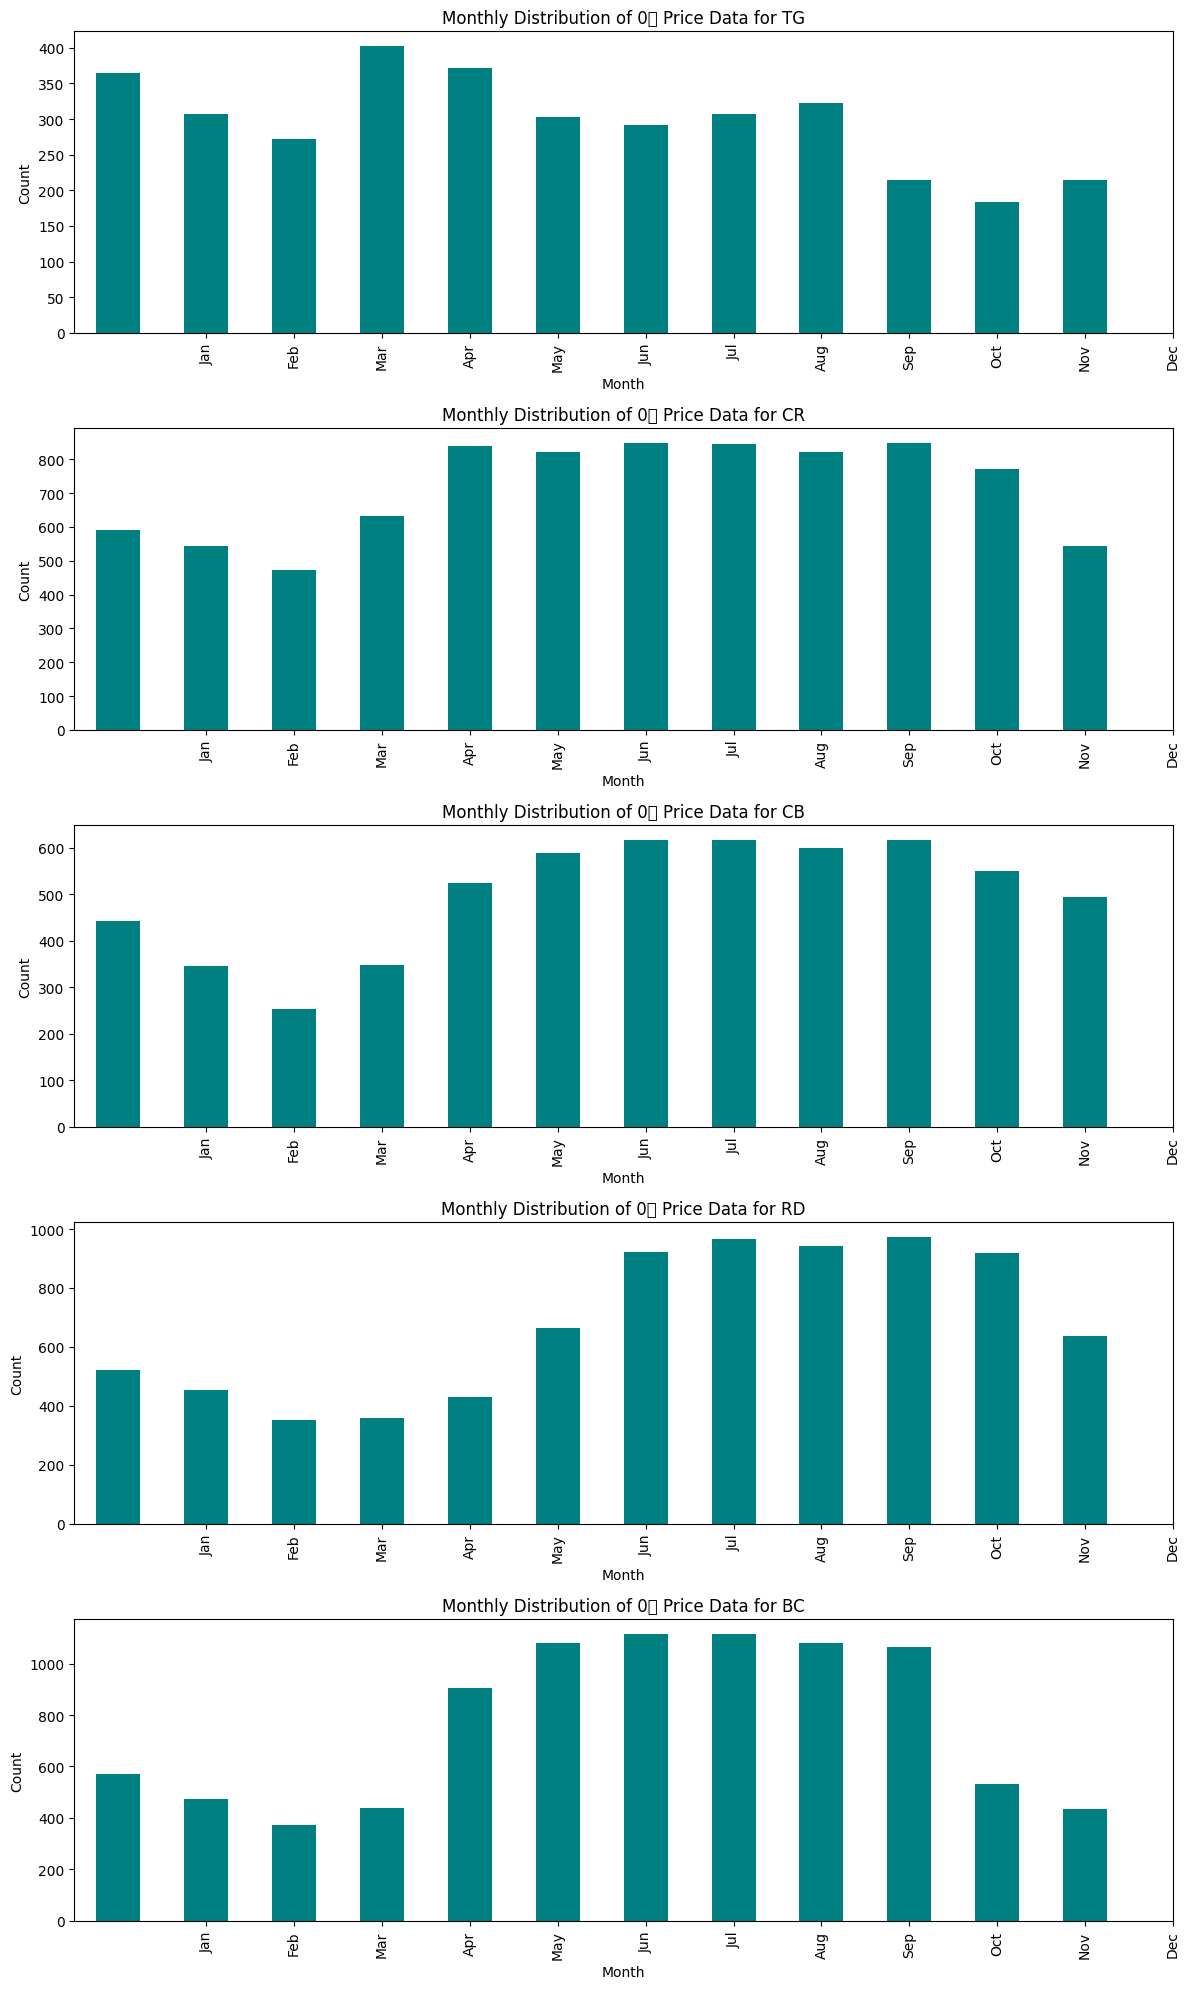

In [18]:
# Plot the month-wise distribution for each item
fig, axes = plt.subplots(len(items), 1, figsize=(12, 4 * len(items)))

for idx, item in enumerate(items):
    monthly_counts = zero_price_df[zero_price_df['item'] == item]['timestamp'].astype('datetime64').dt.month.value_counts().sort_index()
    monthly_counts.plot(kind='bar', ax=axes[idx], color='teal')
    axes[idx].set_title(f'Monthly Distribution of 0원 Price Data for {item}')
    axes[idx].set_xlabel('Month')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(range(1, 13))
    axes[idx].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()


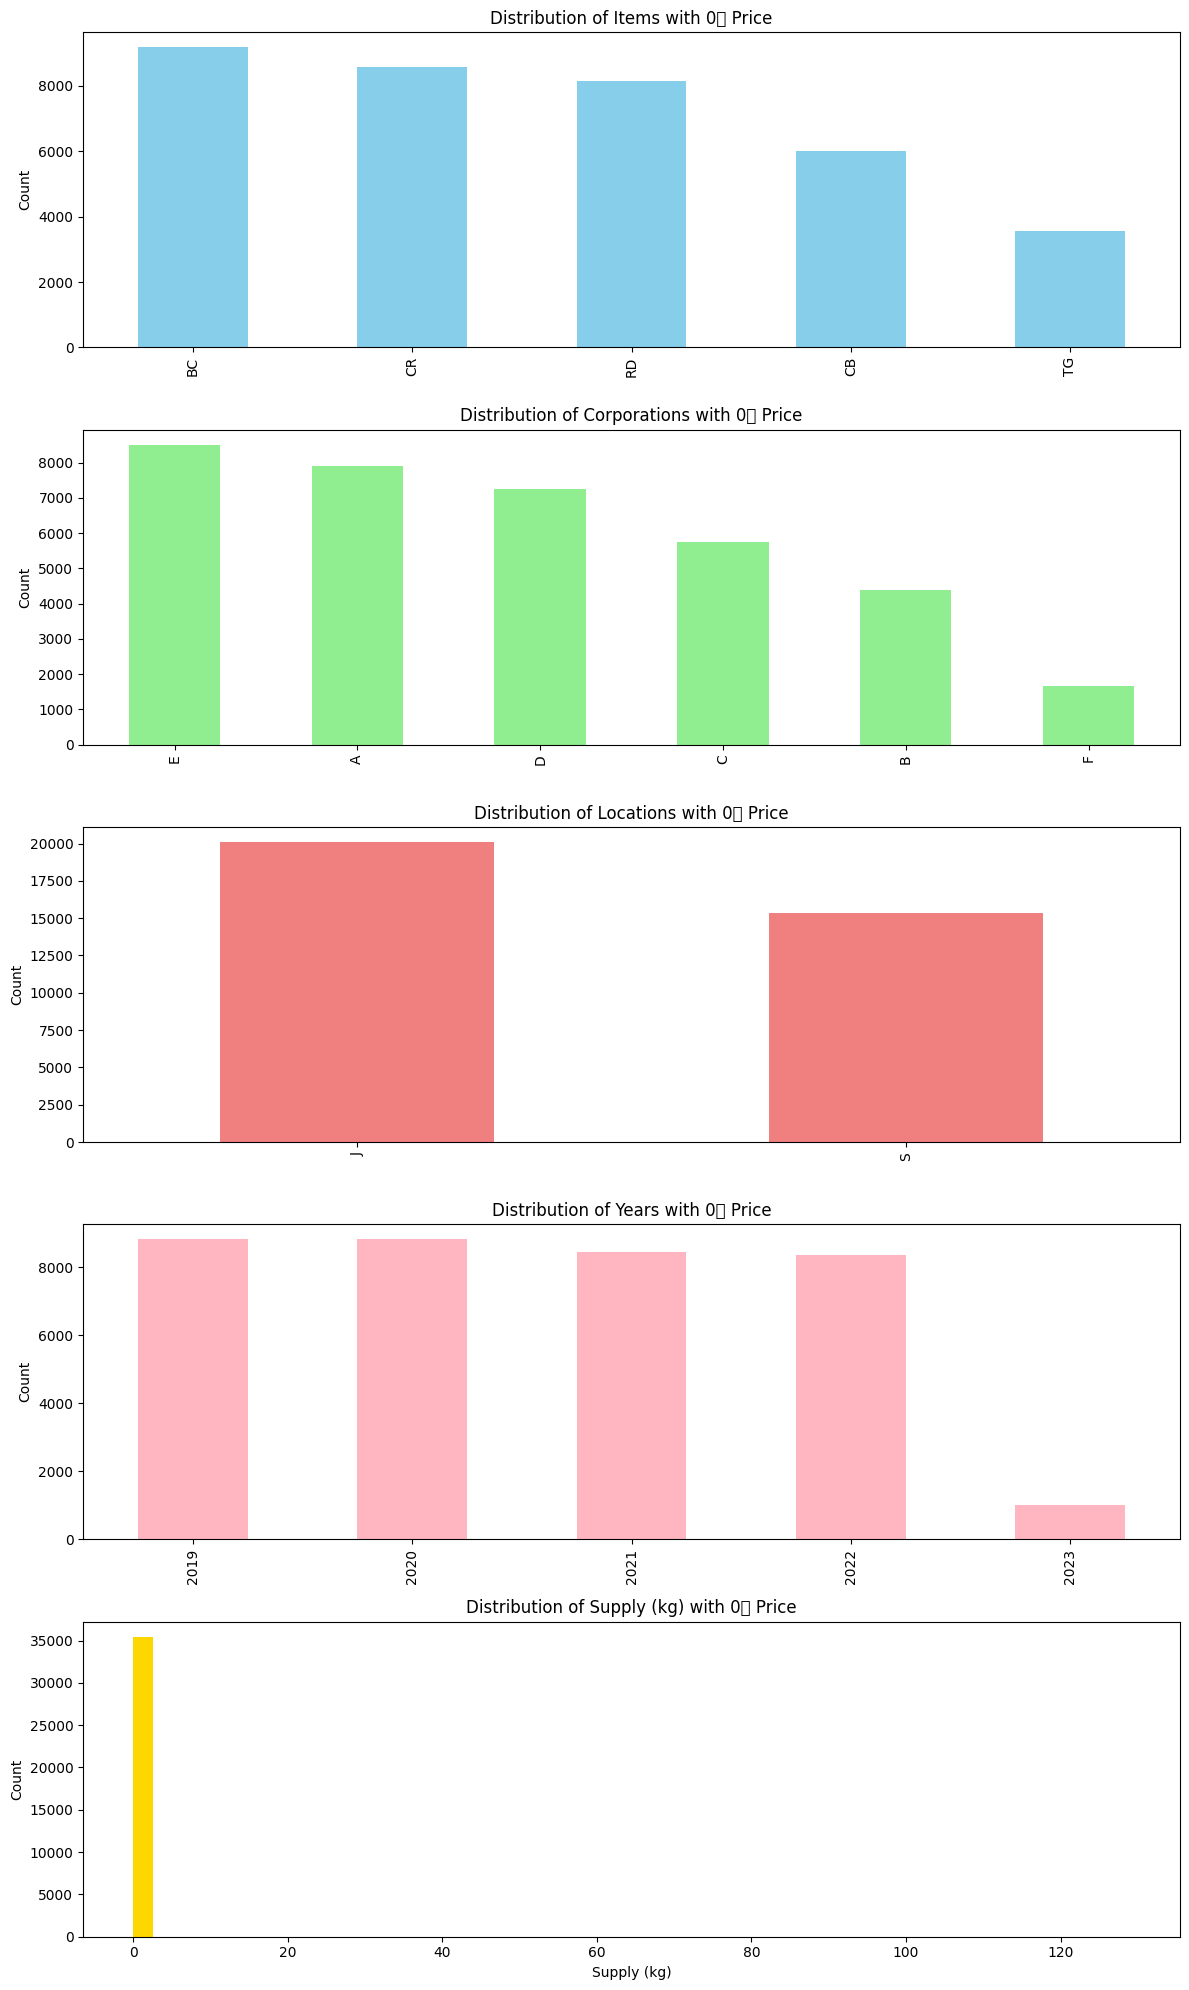

In [19]:
fig, axes = plt.subplots(5, 1, figsize=(12, 20))

# 1. Item distribution
zero_price_df['item'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Items with 0원 Price')
axes[0].set_ylabel('Count')

# 2. Corporation distribution
zero_price_df['corporation'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution of Corporations with 0원 Price')
axes[1].set_ylabel('Count')

# 3. Location distribution
zero_price_df['location'].value_counts().plot(kind='bar', ax=axes[2], color='lightcoral')
axes[2].set_title('Distribution of Locations with 0원 Price')
axes[2].set_ylabel('Count')

# 4. Year distribution
zero_price_df['timestamp'].astype('datetime64').dt.year.value_counts().sort_index().plot(kind='bar', ax=axes[3], color='lightpink')
axes[3].set_title('Distribution of Years with 0원 Price')
axes[3].set_ylabel('Count')

# 5. Supply distribution
zero_price_df['supply(kg)'].plot(kind='hist', bins=50, ax=axes[4], color='gold')
axes[4].set_title('Distribution of Supply (kg) with 0원 Price')
axes[4].set_xlabel('Supply (kg)')
axes[4].set_ylabel('Count')

plt.tight_layout()
plt.show()
